# 06 - Matrix Plots in Seaborn

## Goal
Learn matrix-style visualizations:
- **Heatmaps** for correlation matrices and confusion matrices
- **Clustermaps** for hierarchical clustering
- **Annotations + masking** (e.g., hide upper triangle for correlations)
- **Centered diverging colormaps** for values like correlations (−1 to 1)
- **Robust color scaling** to reduce sensitivity to outliers

## Quick cheat sheet
| Task | Function | Key params |
|---|---|---|
| Correlation matrix | `sns.heatmap()` | `annot`, `fmt`, `cmap`, `center`, `vmin/vmax`, `mask` |
| Confusion matrix | `sns.heatmap()` | `annot`, `fmt`, `cmap`, `cbar=False`, axis labels |
| Hierarchical clustering | `sns.clustermap()` | `standard_scale`, `z_score`, `method`, `metric`, `cmap` |
| Mask upper triangle | `mask=np.triu(...)` | Combine with `center=0` for correlations |
| Robust color scale | `robust=True` | Uses robust quantiles for color limits |

## When to use what
- Use **heatmap** when row/column order is meaningful or fixed.
- Use **clustermap** when you want to discover **groups** of similar rows/columns.


In [1]:
# Setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white', context='notebook')
np.random.seed(42)


## 0) Synthetic dataset (real-world style): e-commerce KPIs
We will generate a dataset that looks like weekly e-commerce performance:
- Acquisition: `ad_spend`, `sessions`
- Funnel: `add_to_cart_rate`, `checkout_rate`, `conversion_rate`
- Business outcomes: `orders`, `aov` (avg order value), `revenue`, `return_rate`

This dataset is synthetic but designed to have plausible relationships:
- More spend → more sessions
- Better funnel rates → higher conversion → more orders → more revenue
- Very high return rate reduces net revenue quality


In [2]:
# Create a synthetic e-commerce KPI dataset (weekly)
n = 120  # weeks

# Marketing + traffic
ad_spend = np.random.lognormal(mean=9.0, sigma=0.35, size=n)  # in currency units
sessions = (ad_spend / 20 + np.random.normal(0, 1200, size=n)).clip(2000, None)

# Funnel rates (bounded 0..1)
add_to_cart_rate = np.clip(0.06 + 0.000002 * sessions + np.random.normal(0, 0.01, n), 0.02, 0.25)
checkout_rate = np.clip(0.35 + 0.25 * add_to_cart_rate + np.random.normal(0, 0.03, n), 0.10, 0.80)
conversion_rate = np.clip(0.008 + 0.045 * add_to_cart_rate + 0.020 * checkout_rate + np.random.normal(0, 0.003, n), 0.002, 0.08)

# Outcomes
orders = (sessions * conversion_rate + np.random.normal(0, 25, n)).clip(10, None)

# Average order value influenced by discounting (not modeled explicitly) + some noise
# (add some correlation with checkout_rate as a proxy for checkout UX)
aov = np.clip(900 + 600 * checkout_rate + np.random.normal(0, 120, n), 300, 2500)

revenue = orders * aov

# Return rate: mildly correlated with higher AOV + random seasonality
season = np.sin(np.linspace(0, 6*np.pi, n))
return_rate = np.clip(0.10 + 0.00002 * (aov - 900) + 0.03 * (season > 0) + np.random.normal(0, 0.02, n), 0.02, 0.35)

# Add a few extreme outliers to demonstrate robust scaling
outlier_weeks = np.random.choice(np.arange(n), size=4, replace=False)
revenue[outlier_weeks] *= np.random.uniform(2.5, 4.5, size=4)

kpi = pd.DataFrame({
    'ad_spend': ad_spend,
    'sessions': sessions,
    'add_to_cart_rate': add_to_cart_rate,
    'checkout_rate': checkout_rate,
    'conversion_rate': conversion_rate,
    'orders': orders,
    'aov': aov,
    'revenue': revenue,
    'return_rate': return_rate,
})

kpi.head()


,ad_spend,sessions,add_to_cart_rate,checkout_rate,conversion_rate,orders,aov,revenue,return_rate
0,9641.673321,2000.000000,0.056075,0.379599,0.017732,54.387905,1164.695668,178845.803412,0.104305
1,7720.292220,2000.000000,0.062853,0.411695,0.016196,10.000000,941.796989,9417.969887,0.144332
2,10164.850192,2191.595683,0.069433,0.364095,0.013587,51.517486,956.675026,49285.492276,0.108679
3,13808.787581,2000.000000,0.072658,0.380216,0.019484,72.859538,1217.321135,88693.454946,0.143995
4,7465.489786,2000.000000,0.051997,0.383704,0.015745,41.825644,1150.726000,48129.856576,0.138344


In [3]:
# Basic checks
print(kpi.shape)
print(kpi.describe().round(3))


(120, 9)
        ad_spend  sessions  add_to_cart_rate  checkout_rate  conversion_rate  \
count    120.000   120.000           120.000        120.000          120.000   
mean    8301.387  2082.915             0.064          0.368            0.018   
std     2753.223   371.730             0.009          0.032            0.003   
min     3239.224  2000.000             0.032          0.294            0.011   
25%     6633.319  2000.000             0.058          0.345            0.016   
50%     7898.043  2000.000             0.064          0.368            0.018   
75%     9264.864  2000.000             0.071          0.386            0.020   
max    19189.811  5108.163             0.085          0.459            0.025   

        orders       aov     revenue  return_rate  
count  120.000   120.000     120.000      120.000  
mean    39.361  1125.663   46684.417        0.123  
std     24.032   116.821   32311.636        0.024  
min     10.000   882.190    9341.055        0.071  
25%     17

## 1) Heatmaps: correlation matrix
A correlation heatmap summarizes how variables move together.

### Best practices for correlations
- Use a **diverging colormap** centered at 0.
- Set `vmin=-1` and `vmax=1` for correlations.
- Use **masking** to show only the lower triangle (avoids duplicate info).
- `annot=True` is great for small matrices; for large matrices it can be cluttered.


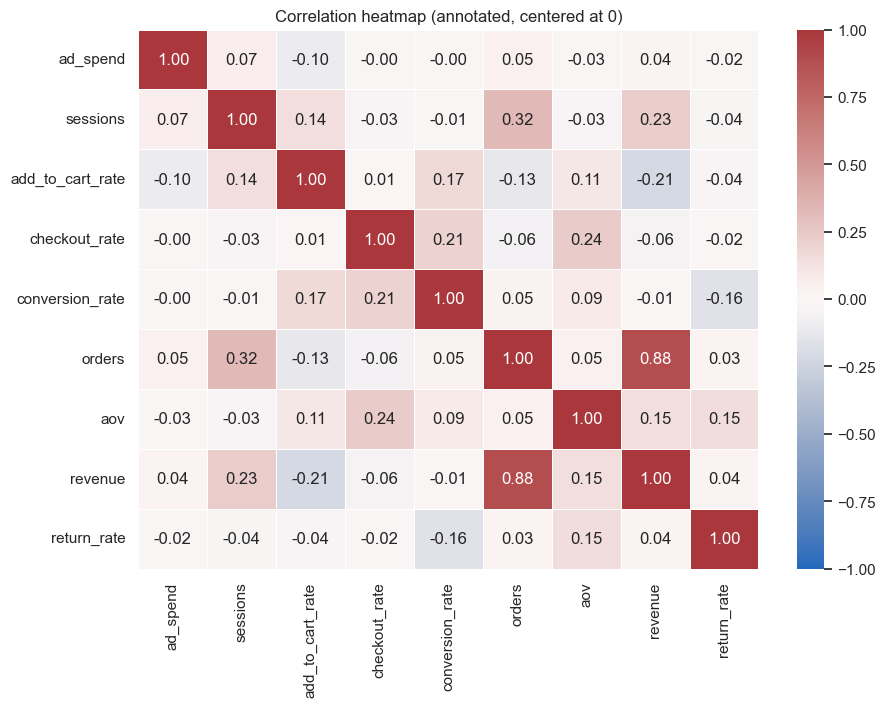

In [4]:
# Correlation matrix
corr = kpi.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr,
    cmap='vlag',
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation heatmap (annotated, centered at 0)')
plt.show()


### Masking the upper triangle
Masking makes correlation heatmaps cleaner by removing mirrored duplicates.


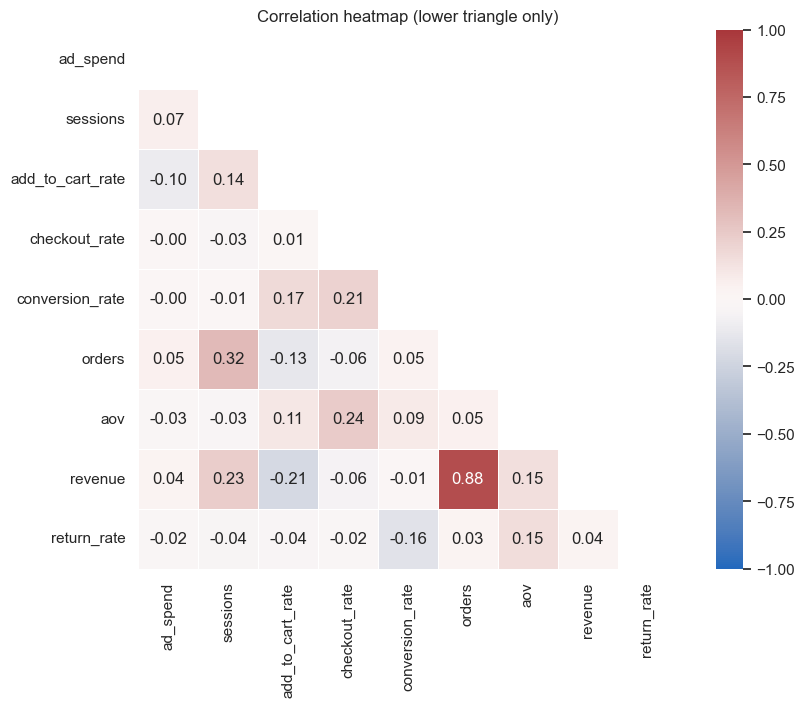

In [5]:
# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr,
    mask=mask,
    cmap='vlag',
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    square=True
)
plt.title('Correlation heatmap (lower triangle only)')
plt.show()


## 2) Center & robust scaling

### `center=0`
For diverging data like correlations, set `center=0` so:
- negative values map to one side (e.g., blue)
- positive values map to the other side (e.g., red)

### `robust=True`
If a matrix contains extreme values/outliers, `robust=True` uses robust quantiles to set color limits.

In our synthetic data, we injected outlier weeks in revenue; this can skew distributions.


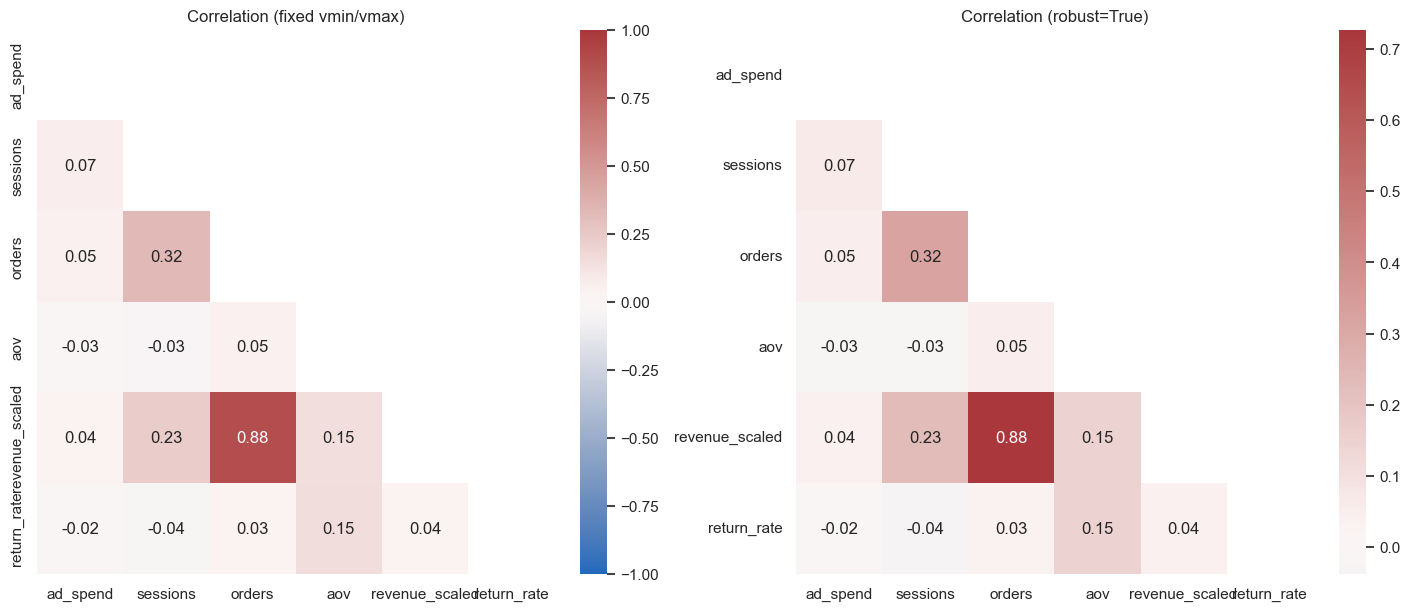

In [6]:
# Compare robust vs non-robust on a covariance-like matrix
# Create a "scaled revenue" feature to amplify outlier impact
kpi2 = kpi.copy()
kpi2['revenue_scaled'] = kpi2['revenue'] / 1e6

corr2 = kpi2[['ad_spend','sessions','orders','aov','revenue_scaled','return_rate']].corr()
mask2 = np.triu(np.ones_like(corr2, dtype=bool))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

sns.heatmap(
    corr2,
    mask=mask2,
    cmap='vlag',
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    ax=axes[0]
)
axes[0].set_title('Correlation (fixed vmin/vmax)')

sns.heatmap(
    corr2,
    mask=mask2,
    cmap='vlag',
    center=0,
    robust=True,
    annot=True,
    fmt='.2f',
    ax=axes[1]
)
axes[1].set_title('Correlation (robust=True)')

plt.show()


## 3) Heatmaps: confusion matrix (classification)
A confusion matrix is common in real-world ML evaluation (e.g., churn prediction, fraud detection).

### Example scenario
A model predicts whether a customer will **churn** (`1`) or not (`0`).

We will create synthetic ground-truth labels and predicted labels, then plot a confusion matrix.

Tip: For confusion matrices, a **sequential colormap** (e.g., `Blues`) is usually better than diverging.


In [7]:
# Synthetic churn labels
m = 1200
true_churn = (np.random.rand(m) < 0.22).astype(int)  # 22% churn

# A model with some skill: higher recall than random, but not perfect
# Generate predicted probabilities with some separation
scores = np.where(true_churn == 1,
                  np.random.beta(4, 3, size=m),   # churners have higher scores
                  np.random.beta(2, 6, size=m))   # non-churners have lower scores

threshold = 0.45
pred_churn = (scores >= threshold).astype(int)

# Confusion matrix counts
# rows = true, cols = predicted
cm = pd.crosstab(
    pd.Series(true_churn, name='True'),
    pd.Series(pred_churn, name='Predicted')
)

cm


Predicted,0,1
True,,
0,833,106
1,62,199


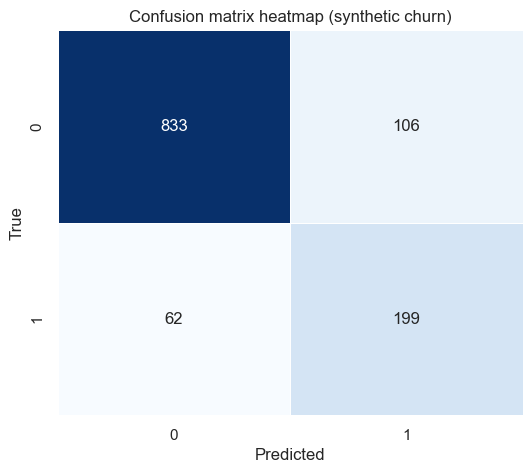

In [8]:
# Plot confusion matrix with annotations
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=0.5
)
plt.title('Confusion matrix heatmap (synthetic churn)')
plt.show()


## 4) Clustermaps (`clustermap`)
`clustermap()` performs hierarchical clustering and reorders rows/columns to group similar patterns.

### When to use
- Feature correlation blocks
- Customer/product cohorts (rows) vs behaviors (columns)

### Key parameters
- `standard_scale=1`: standardize columns (good when features are on different scales)
- `z_score=0`: z-score rows
- `method`: linkage method (`'average'`, `'complete'`, `'ward'`)
- `metric`: distance metric (`'euclidean'`, `'correlation'`)

Important: `clustermap` creates its own figure (similar to `lmplot`).


In [9]:
# Create a cohort-style dataset: product categories vs weekly metrics
categories = ['Electronics', 'Fashion', 'Home', 'Beauty', 'Sports', 'Books']
weeks = pd.date_range('2024-01-01', periods=24, freq='W')

rows = []
for cat in categories:
    cat_factor = {
        'Electronics': (1.3, 1.15),
        'Fashion': (1.0, 0.95),
        'Home': (0.9, 1.05),
        'Beauty': (0.85, 1.10),
        'Sports': (1.05, 1.00),
        'Books': (0.7, 0.90),
    }[cat]
    spend_factor, conv_factor = cat_factor

    for w in weeks:
        base_spend = np.random.lognormal(8.5, 0.25) * spend_factor
        base_sessions = (base_spend / 18 + np.random.normal(0, 900)).clip(1500, None)
        base_conv = np.clip(np.random.normal(0.018, 0.004) * conv_factor, 0.005, 0.05)
        base_aov = np.clip(np.random.normal(1200, 220) * (1.15 if cat == 'Electronics' else 0.95), 300, 3500)
        base_orders = base_sessions * base_conv
        base_revenue = base_orders * base_aov

        rows.append({
            'category': cat,
            'week': w,
            'ad_spend': base_spend,
            'sessions': base_sessions,
            'conversion_rate': base_conv,
            'aov': base_aov,
            'revenue': base_revenue,
        })

cohort = pd.DataFrame(rows)

# Aggregate by category (mean over weeks)
cohort_mean = cohort.groupby('category')[['ad_spend','sessions','conversion_rate','aov','revenue']].mean()
cohort_mean


AttributeError: 'float' object has no attribute 'clip'

In [ ]:
# Clustermap on category-level KPIs
# standard_scale=1 standardizes each column so clustering isn't dominated by high-magnitude features like revenue
sns.clustermap(
    cohort_mean,
    standard_scale=1,
    method='average',
    metric='euclidean',
    cmap='mako',
    linewidths=0.5,
    figsize=(8, 6)
)
plt.suptitle('Clustermap: product category KPIs (standardized by column)', y=1.02)
plt.show()


---
## Practice set
Use `kpi` and `cohort_mean` from above.

### A) Correlation heatmaps
1. Create a correlation matrix heatmap for `kpi` with `annot=False` and `linewidths=0.3`.
2. Mask the upper triangle.
3. Try a different diverging colormap (e.g., `coolwarm`) and compare.

### B) Confusion matrix
4. Change the churn threshold to `0.55`. Recompute the confusion matrix and replot.
5. Compute and print precision and recall from the confusion matrix (challenge).

### C) Clustering
6. Try `metric='correlation'` and compare clusters.
7. Try `method='complete'`.

### Challenge
8. Write a function `plot_corr_triangle(df)` that:
   - computes correlations
   - masks the upper triangle
   - plots a centered diverging heatmap


In [ ]:
# Practice template (fill TODOs)

# TODO A1-A3

# TODO B4

# TODO B5 (challenge): precision, recall

# TODO C6-C7

from typing import Any

def plot_corr_triangle(df: pd.DataFrame, **kwargs: Any):
    # TODO: implement masked correlation heatmap
    pass


## Reference links
- Seaborn heatmap API: https://seaborn.pydata.org/generated/seaborn.heatmap.html
- Seaborn clustermap API: https://seaborn.pydata.org/generated/seaborn.clustermap.html
